### Importing the Functions


In [1]:
# Misc
from IPython import get_ipython
from IPython.display import display
import hashlib
import os
from pprint import pprint
from time import monotonic
import ipywidgets as widgets
import sys
from tabulate import tabulate
from rich import print
from rich.console import Console
from rich.table import Table

# Data Wrangling
import pandas as pd
import numpy as numpy

# Data Manipulation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx

# Project Source Code
src_path = os.path.abspath(os.path.join(os.getcwd(), "../../../src"))
sys.path.append(src_path)
from helpers import add_cell_timer, currency

# Machine Learning 
from sklearn.ensemble import RandomForestClassifier
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GCNConv, GATConv
import xgboost as xgb

# Result Metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss, matthews_corrcoef, balanced_accuracy_score


add_cell_timer()

In [2]:
class GNN_base(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN_base, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)  # Activation
        x = self.conv2(x, edge_index)
        return F.softmax(x, dim=1) 

# Define the Enhanced GNN Model
class GNN_arch1(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=4):
        super(GNN_arch1, self).__init__()

        # Initial Graph Convolutional Layer (GCN)
        self.gcn1 = GCNConv(input_dim, hidden_dim)

        # Graph Attention Layer (GAT)
        self.gat1 = GATConv(hidden_dim, hidden_dim, heads=heads, concat=False)

        # Fully Connected Layer for Node Classification
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, output_dim)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, edge_index):
        # Apply GCN
        x = self.gcn1(x, edge_index)
        x = F.relu(x)

        # Apply GAT for attention-based feature learning
        x = self.gat1(x, edge_index)
        x = F.relu(x)

        # Fully connected layers for **node-level classification**
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)  

### Pipeline for the process

In [4]:
class model_pipeline:

    def __init__(self, df_path, random_state_):

        self.df_path = df_path
        self.df = pd.read_csv(self.df_path)
        self.random_state_ = random_state_

        self.X = None
        self.y = None

        self.X_train = None
        self.y_train = None

        self.X_test = None
        self.y_test = None

        self.X_val = None
        self.y_val = None

        self.y_pred = None
        self.y_proba = None

        self.model = None

    def df_summary(self):
        print('DATA HEAD')
        display(self.df.head())
        print('FEATURE TYPE')
        display(self.df.info())

    def y_statistics(self):
        print('Normalised Value Count: ')
        print(self.df['Is Laundering'].value_counts(normalize=True))

    # Feature Transformation

    def currency_normalization(self):
        usd_conversion = currency.get_usd_conversion(self.df_path)
        self.df['Amount Paid (USD)'] = self.df.apply(lambda row: row['Amount Paid'] * usd_conversion.get(row['Payment Currency'], 1), axis=1)
        self.df['Amount Received (USD)'] = self.df.apply(lambda row: row['Amount Received'] * usd_conversion.get(row['Receiving Currency'], 1), axis=1)

    def date_to_unix(self):
        self.df['Timestamp'] = pd.to_datetime(self.df['Timestamp']).astype(int) / 10**9 

    def label_encoding(self, features_to_encode):
        for col in features_to_encode:
            self.df[col] = LabelEncoder().fit_transform(self.df[col])

    def neighbor_context(self):
        G = nx.DiGraph()

        for _, row in self.df.iterrows():
            G.add_edge(row['Account'], row['Account.1'], weight=row['Amount Paid (USD)'])

        self.df['degree_centrality'] = self.df['Account'].map(nx.degree_centrality(G))
        self.df['pagerank'] = self.df['Account'].map(nx.pagerank(G))

    def generate_tensor(self,edge_features):
        self.train_node_features = torch.tensor(self.X_train[edge_features].values, dtype=torch.float)
        labels = torch.tensor(self.y_train.values, dtype=torch.long)
        edge_index = torch.tensor(self.X_train[["Account", "Account.1"]].values.T, dtype=torch.long)
        self.train_data = Data(x=self.train_node_features, edge_index=edge_index, y=labels)

        self.test_node_features = torch.tensor(self.X_test[edge_features].values, dtype=torch.float)
        labels = torch.tensor(self.y_test.values, dtype=torch.long)
        edge_index = torch.tensor(self.X_test[["Account", "Account.1"]].values.T, dtype=torch.long)
        self.test_data = Data(x=self.test_node_features, edge_index=edge_index, y=labels)
    
    def split_x_y(self, X_cols, y_col):
        self.X = self.df[X_cols]
        self.y = self.df[y_col]

    def split_train_test(self, test_size_):
        # Random Split For now
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=test_size_, random_state=self.random_state_, stratify=self.y)
        # print(self.X_train.shape)
        # print(self.X_test.shape)
        # print(self.y_train.shape)
        # print(self.y_test.shape)
    
    def random_forest_classifier(self, param):      
        self.model = RandomForestClassifier(**param)
        self.model.fit(self.X_train, self.y_train)

    def xgboost_classifier(self,param):
        self.dtrain = xgb.DMatrix(self.X_train, label=self.y_train)
        self.dtest = xgb.DMatrix(self.X_test, label=self.y_test)
        self.model = xgb.train(param, self.dtrain)


    def training_gnn_model(self, learning_rate, epoch_,gnn_model):
            
        self.model = globals()[gnn_model](input_dim=self.train_node_features.shape[1], hidden_dim=16, output_dim=2)
        # Define optimizer and loss function
        optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.model.to(device)
        self.train_data = self.train_data.to(device)

        # Training loop
        epochs = epoch_
        for epoch in range(epochs):
            self.model.train()
            optimizer.zero_grad()
            out = self.model(self.train_data.x, self.train_data.edge_index)
            loss = criterion(out, self.train_data.y)
            loss.backward()
            optimizer.step()
            
            if epoch % 10 == 0:
                print(f"Epoch {epoch} - Loss: {loss.item():.4f}")

    def predict_model_gnn(self):
        self.model.eval()
        with torch.no_grad():
            out_probs = self.model(self.test_data.x, self.test_data.edge_index)
            self.y_proba = out_probs.cpu().numpy()
            self.y_pred = out_probs.argmax(dim=1).cpu().numpy()

    def predict_model(self, xgboost_flag = 'null'):
        if xgboost_flag == 'null':
            self.y_pred = self.model.predict(self.X_test)
            self.y_proba = self.model.predict_proba(self.X_test)
        else:
            self.y_proba = self.model.predict(self.dtest)
            self.y_pred = (self.y_proba > 0.5).astype(int)

    def result_metrics(self):

        print(classification_report(self.y_test, self.y_pred, digits=4))


        cm = confusion_matrix(self.y_test, self.y_pred)
        accuracy = balanced_accuracy_score(self.y_test, self.y_pred) 
        mcc = matthews_corrcoef(self.y_test, self.y_pred)
        logloss = log_loss(self.y_test, self.y_proba) if self.y_proba is not None else None

        print(f"Balanced Accuracy: {accuracy:.4f}")
        print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
        if logloss:
            print(f"Log Loss: {logloss:.4f}")


        if self.y_proba is not None:

            if len(self.y_proba.shape) == 1:
                fpr, tpr, _ = roc_curve(self.y_test, self.y_proba)
                roc_auc = roc_auc_score(self.y_test, self.y_proba)
                precision, recall, _ = precision_recall_curve(self.y_test, self.y_proba)
                pr_auc = auc(recall, precision)
            else:
                fpr, tpr, _ = roc_curve(self.y_test, self.y_proba[:, 1])
                roc_auc = roc_auc_score(self.y_test, self.y_proba[:, 1])
                precision, recall, _ = precision_recall_curve(self.y_test, self.y_proba[:, 1])
                pr_auc = auc(recall, precision)

            print(f"AUC-ROC Score: {roc_auc:.4f}")
            print(f"Precision-Recall AUC: {pr_auc:.4f}")


            fig, axes = plt.subplots(1, 3, figsize=(18, 5))

            class_labels = ["Licit", "Illicit"] 
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0])
            axes[0].set_title("Confusion Matrix")
            axes[0].set_xlabel("Predicted Label")
            axes[0].set_ylabel("True Label")
            axes[0].set_xticklabels(class_labels)
            axes[0].set_yticklabels(class_labels)

            axes[1].plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.4f}')
            axes[1].plot([0, 1], [0, 1], linestyle="--", color="gray")  # Baseline
            axes[1].set_title("ROC Curve")
            axes[1].set_xlabel("False Positive Rate")
            axes[1].set_ylabel("True Positive Rate")
            axes[1].legend()


            axes[2].plot(recall, precision, label=f'PR AUC = {pr_auc:.4f}')
            axes[2].set_title("Precision-Recall Curve")
            axes[2].set_xlabel("Recall")
            axes[2].set_ylabel("Precision")
            axes[2].legend()

            plt.tight_layout()
            plt.show()



⏱️ Execution time: 0.0s


### RF Without Contextuality

              precision    recall  f1-score   support

           0     0.9991    0.9999    0.9995   1014634
           1     0.6810    0.1382    0.2297      1035

    accuracy                         0.9991   1015669
   macro avg     0.8400    0.5690    0.6146   1015669
weighted avg     0.9988    0.9991    0.9987   1015669

Balanced Accuracy: 0.5690
Matthews Correlation Coefficient (MCC): 0.3065
Log Loss: 0.0236
AUC-ROC Score: 0.6893
Precision-Recall AUC: 0.1815


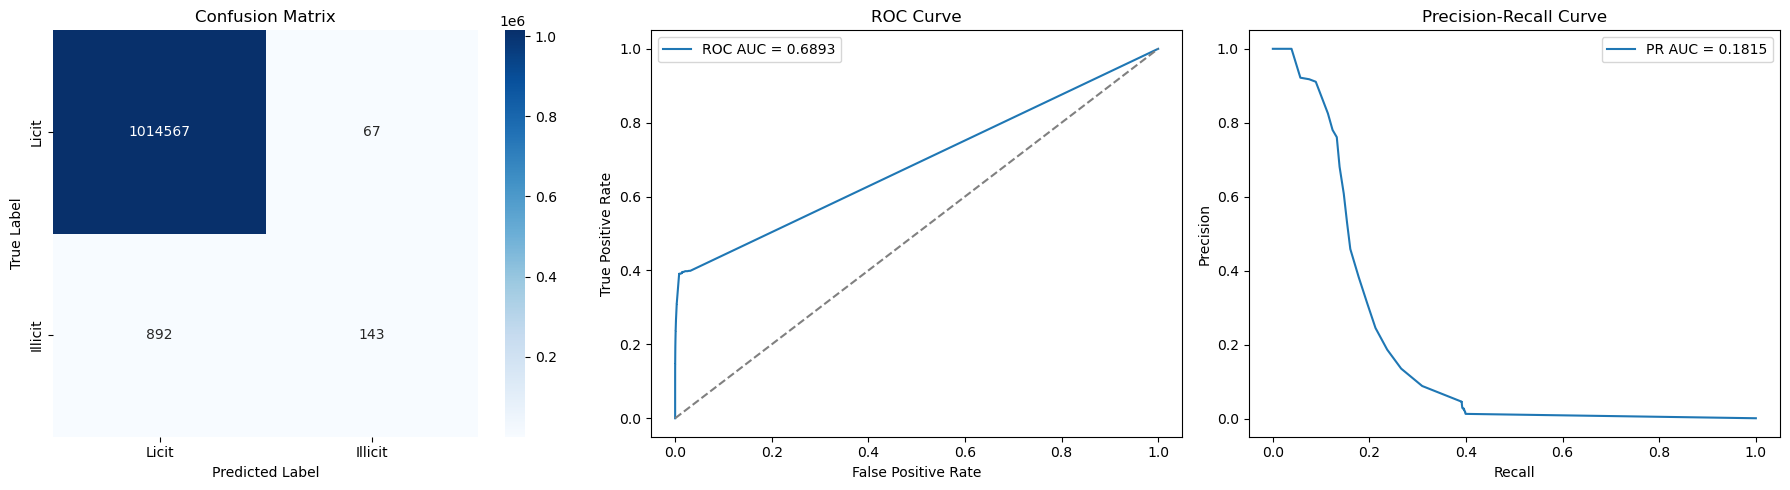


⏱️ Execution time: 192.97s


In [5]:
rf = model_pipeline(df_path='/Users/abhitay/Developer/Columbia_projects/CAP/dsi-capstone-spring-2025-TD-anti-money-laundering/Code/Abhitay/IBM/HI-Small_Trans.csv',random_state_=42)
rf.currency_normalization()
rf.date_to_unix()
rf.label_encoding(['Receiving Currency', 'Payment Currency', 'Payment Format','Account.1','Account'])

X_cols = ['Timestamp','Amount Paid (USD)','Amount Received (USD)','Payment Currency','Payment Format']
y_col = 'Is Laundering'
rf.split_x_y(X_cols=X_cols, y_col=y_col)
rf.split_train_test(test_size_=0.2)

rf.random_forest_classifier(param={'n_estimators': 20, 'random_state':42})
rf.predict_model()
rf.result_metrics()

In [ ]:
# Data Wrangling
import pandas as pd
import numpy as numpy

# Data Manipulation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from Code.src.helpers  import currency

# Machine Learning 
from sklearn.ensemble import RandomForestClassifier

# Result Metrics
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import confusion_matrix

### XGBoost Without Contextuality

              precision    recall  f1-score   support

           0     0.9991    1.0000    0.9995   1014634
           1     0.8506    0.1266    0.2204      1035

    accuracy                         0.9991   1015669
   macro avg     0.9249    0.5633    0.6099   1015669
weighted avg     0.9990    0.9991    0.9987   1015669

Balanced Accuracy: 0.5633
Matthews Correlation Coefficient (MCC): 0.3279
Log Loss: 0.3589
AUC-ROC Score: 0.9140
Precision-Recall AUC: 0.1910


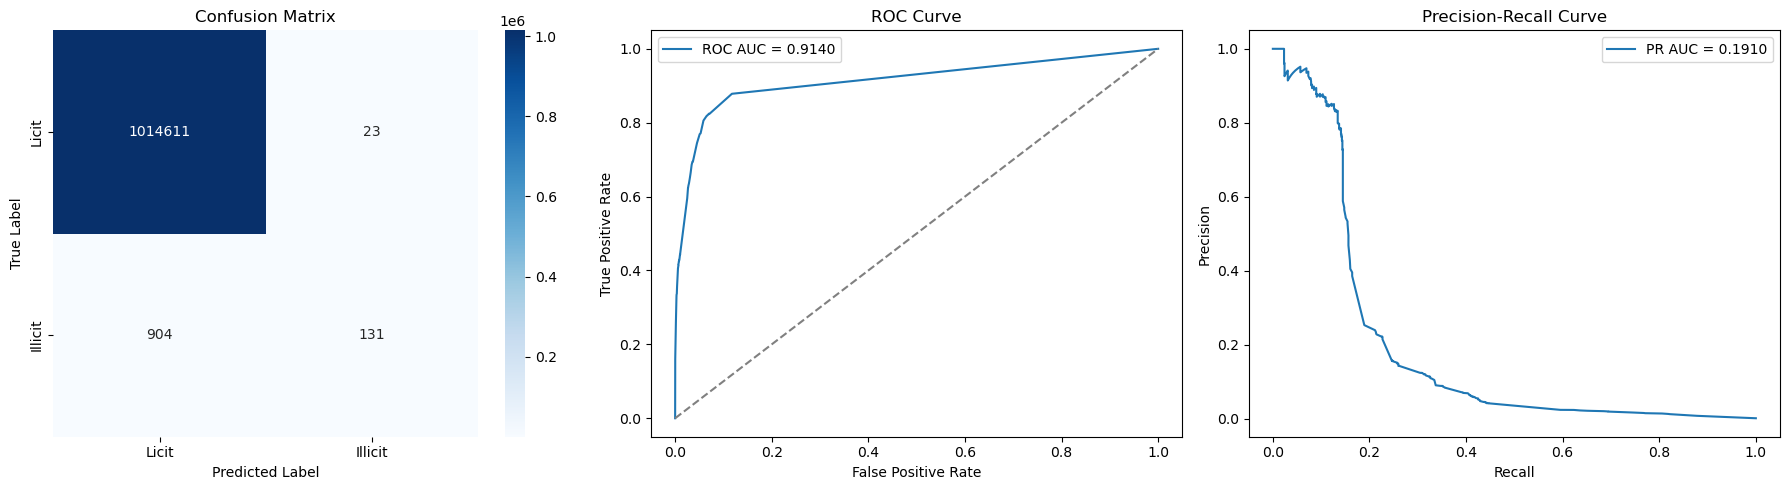


⏱️ Execution time: 66.63s


In [6]:
xgbc = model_pipeline(df_path='/Users/abhitay/Developer/Columbia_projects/CAP/dsi-capstone-spring-2025-TD-anti-money-laundering/Code/Abhitay/IBM/HI-Small_Trans.csv',random_state_=42)
xgbc.currency_normalization()
xgbc.date_to_unix()
xgbc.label_encoding(['Receiving Currency', 'Payment Currency', 'Payment Format','Account.1','Account'])

X_cols = ['Timestamp','Amount Paid (USD)','Amount Received (USD)','Payment Currency','Payment Format']
y_col = 'Is Laundering'
xgbc.split_x_y(X_cols=X_cols, y_col=y_col)
xgbc.split_train_test(test_size_=0.2)
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 8,
    'eta': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}
xgbc.xgboost_classifier(param=params)
xgbc.predict_model(xgboost_flag='True')
xgbc.result_metrics()

### RF With Contextuality

In [7]:
# rfc = model_pipeline(df_path='/Users/abhitay/Developer/Columbia_projects/CAP/dsi-capstone-spring-2025-TD-anti-money-laundering/Code/Abhitay/IBM/HI-Small_Trans.csv',random_state_=42)
# rfc.currency_normalization()
# rfc.date_to_unix()
# rfc.label_encoding(['Receiving Currency', 'Payment Currency', 'Payment Format','Account.1','Account'])
# rfc.neighbor_context()

# X_cols = ['Timestamp','Amount Paid (USD)','Amount Received (USD)','Payment Currency','Payment Format','degree_centrality','pagerank']
# y_col = 'Is Laundering'
# rfc.split_x_y(X_cols=X_cols, y_col=y_col)
# rfc.split_train_test(test_size_=0.2)

# rfc.random_forest_classifier(param={'n_estimators': 20, 'random_state':42})
# rfc.predict_model()
# rfc.result_metrics()


⏱️ Execution time: 0.0s


### Base GNN

Epoch 0 - Loss: 0.3217
Epoch 10 - Loss: 0.3217
Epoch 20 - Loss: 0.3217
Epoch 30 - Loss: 0.3217
Epoch 40 - Loss: 0.3217
Epoch 50 - Loss: 0.3217
Epoch 60 - Loss: 0.3217
Epoch 70 - Loss: 0.3217
Epoch 80 - Loss: 0.3217
Epoch 90 - Loss: 0.3217
              precision    recall  f1-score   support

           0     0.9990    0.9923    0.9956   1014634
           1     0.0012    0.0087    0.0020      1035

    accuracy                         0.9913   1015669
   macro avg     0.5001    0.5005    0.4988   1015669
weighted avg     0.9980    0.9913    0.9946   1015669

Balanced Accuracy: 0.5005
Matthews Correlation Coefficient (MCC): 0.0004
Log Loss: 0.1386
AUC-ROC Score: 0.5005
Precision-Recall AUC: 0.0054


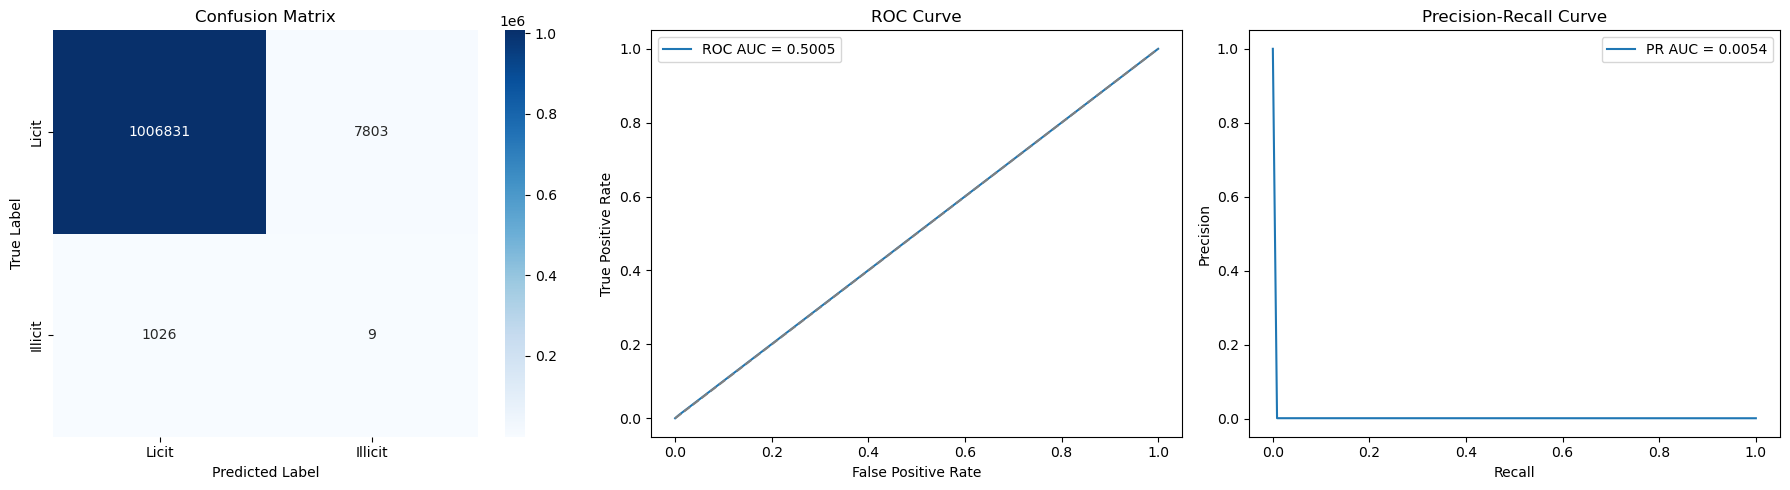


⏱️ Execution time: 309.76s


In [8]:
bgnn = model_pipeline(df_path='/Users/abhitay/Developer/Columbia_projects/CAP/dsi-capstone-spring-2025-TD-anti-money-laundering/Code/Abhitay/IBM/HI-Small_Trans.csv',random_state_=42)
bgnn.currency_normalization()
bgnn.date_to_unix()
bgnn.label_encoding(['Receiving Currency', 'Payment Currency', 'Payment Format','Account.1','Account'])
bgnn.neighbor_context()

X_cols = ['Timestamp','Amount Paid (USD)','Amount Received (USD)','Payment Currency','Payment Format','degree_centrality','pagerank','Account.1','Account']
y_col = 'Is Laundering'
bgnn.split_x_y(X_cols=X_cols, y_col=y_col)
bgnn.split_train_test(test_size_=0.2)

bgnn.generate_tensor(['Timestamp','Amount Paid (USD)','Amount Received (USD)','Payment Currency','Payment Format','degree_centrality','pagerank'])
bgnn.training_gnn_model(learning_rate=0.01,epoch_=100, gnn_model='GNN_base')
bgnn.predict_model_gnn()

bgnn.result_metrics()

### Architecture 1

Epoch 0 - Loss: 6315432.0000
Epoch 10 - Loss: 549888.0000
Epoch 20 - Loss: 317948.3125
Epoch 30 - Loss: 61662.5195
Epoch 40 - Loss: 6759.4331
Epoch 50 - Loss: 725.2058
Epoch 60 - Loss: 118.7656
Epoch 70 - Loss: 104.6583
Epoch 80 - Loss: 25.0686
Epoch 90 - Loss: 90.6175


/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.9990    1.0000    0.9995   1014634
           1     0.0000    0.0000    0.0000      1035

    accuracy                         0.9990   1015669
   macro avg     0.4995    0.5000    0.4997   1015669
weighted avg     0.9980    0.9990    0.9985   1015669



/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Balanced Accuracy: 0.5000
Matthews Correlation Coefficient (MCC): 0.0000
Log Loss: 0.6931
AUC-ROC Score: 0.5000
Precision-Recall AUC: 0.5005


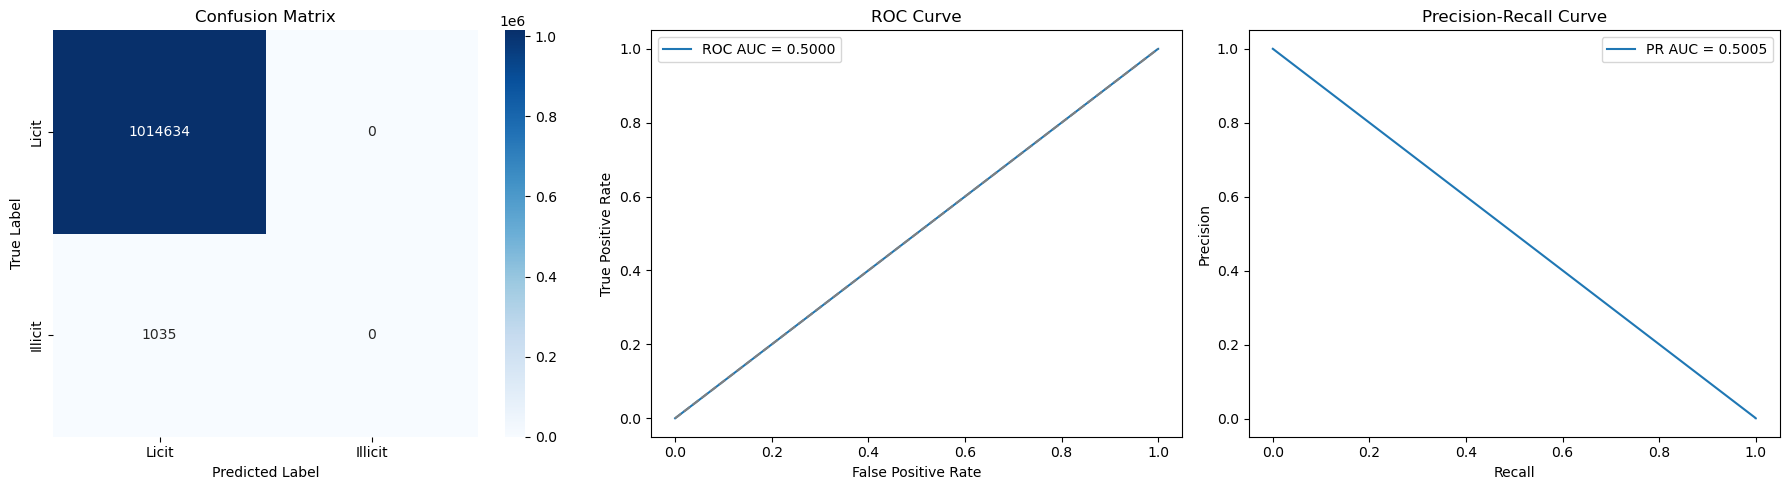


⏱️ Execution time: 1055.25s


In [9]:
a1gnn = model_pipeline(df_path='/Users/abhitay/Developer/Columbia_projects/CAP/dsi-capstone-spring-2025-TD-anti-money-laundering/Code/Abhitay/IBM/HI-Small_Trans.csv',random_state_=42)
a1gnn.currency_normalization()
a1gnn.date_to_unix()
a1gnn.label_encoding(['Receiving Currency', 'Payment Currency', 'Payment Format','Account.1','Account'])
a1gnn.neighbor_context()

X_cols = ['Timestamp','Amount Paid (USD)','Amount Received (USD)','Payment Currency','Payment Format','degree_centrality','pagerank','Account.1','Account']
y_col = 'Is Laundering'
a1gnn.split_x_y(X_cols=X_cols, y_col=y_col)
a1gnn.split_train_test(test_size_=0.2)

a1gnn.generate_tensor(['Timestamp','Amount Paid (USD)','Amount Received (USD)','Payment Currency','Payment Format','degree_centrality','pagerank'])
a1gnn.training_gnn_model(learning_rate=0.01,epoch_=100, gnn_model='GNN_arch1')
a1gnn.predict_model_gnn()

a1gnn.result_metrics()